In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
font = {'family': 'monospace', 'weight': 'medium', 'size': 13}

plt.rc('font', **font)
plt.rc('figure', figsize=(14, 8), dpi=300)

# **GOAL**

Predict the **MEDIAN HOUSE VALUE** in a given district using the provided dataset

### MACHINE LEARNING DESIGN

- **targets/label**: *Supervised Learning*

- **changing dataset ? - NO**: *Batch/offline learning*

- **too large dataset?-NO**: *not out-of-core learning*

In [3]:
# get the dataset

housing = pd.read_csv("../datasets/housing.csv")

housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
# get the info of the dataset

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### **OBSERVATIONS - 1**

- All Attributes are numerical except the ***ocean_proximity*** attribute

- There are missing values in the ***total_bedrooms*** column

---

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

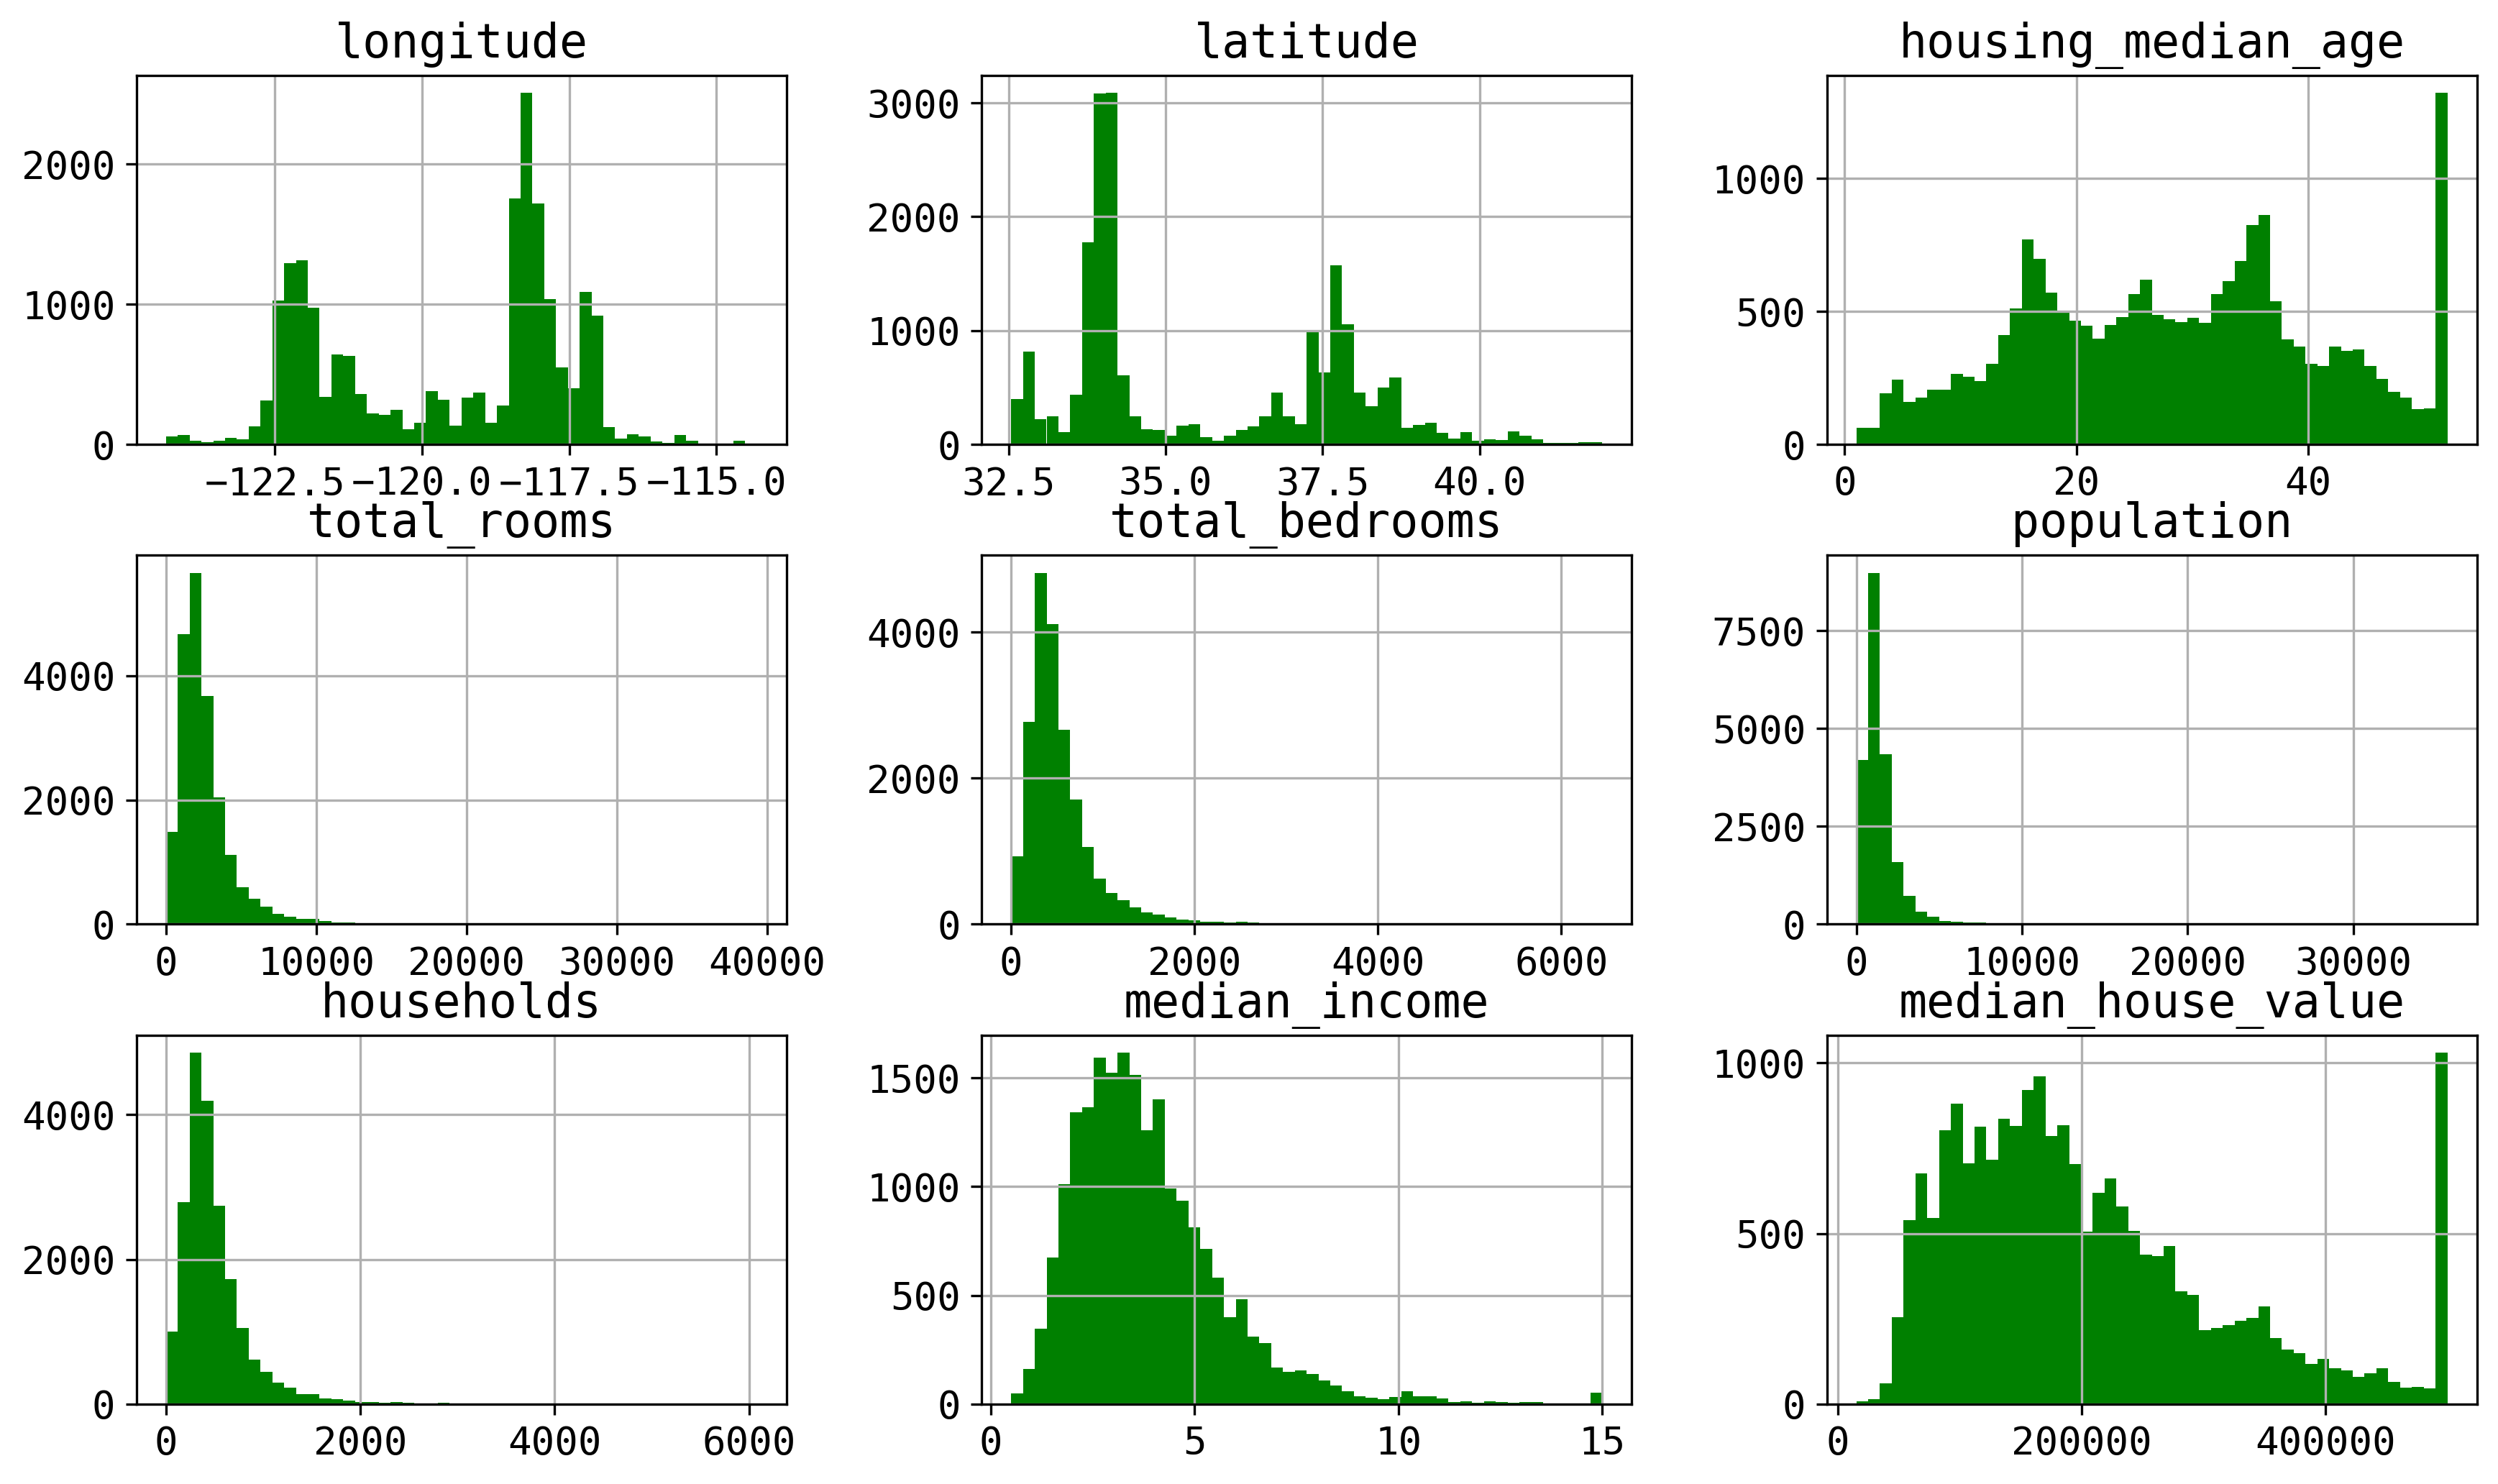

In [5]:
# visualize the dataset distribution

housing.hist(bins=50, grid=True, color='green')

### **OBSERVATION - 2**

- The following attributes (*total_rooms, total_bedrooms, population, housholds, median_income, median_house_value*) have their data skewed to the right, indicating that there are outliers in th dataset on the high side

- The **median_income** values have been scaled down by **ten-thousand dollars**, this indicates that the real value is ten-thousand times the given values

---

## **TRAINING & TEST DATASET**

We want the test set to be representative of the entire dataset, so as to avoid sampling bias which may result in poor generalization. Hence, we use stratified sampling.

However, we must decide on which attribute is the most correlated with the target we we want to predict, and then used that attribute to create a stratified sampling


In [6]:
# get the correlation of all attributes with respect to target

# get only numerical attributes
housing_num = housing.select_dtypes(np.number)

housing_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [7]:
# get the correlation matrix

housing_corr = housing_num.corr('pearson')

housing_corr['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

### **OBSERVATION - 3**

- *median_income* is more correlated with the target attribute.

- how do we stratify the values in the *media_income* column such that the resulting category is not too large?

In [8]:
housing_num.median_income.describe()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

<Axes: ylabel='Frequency'>

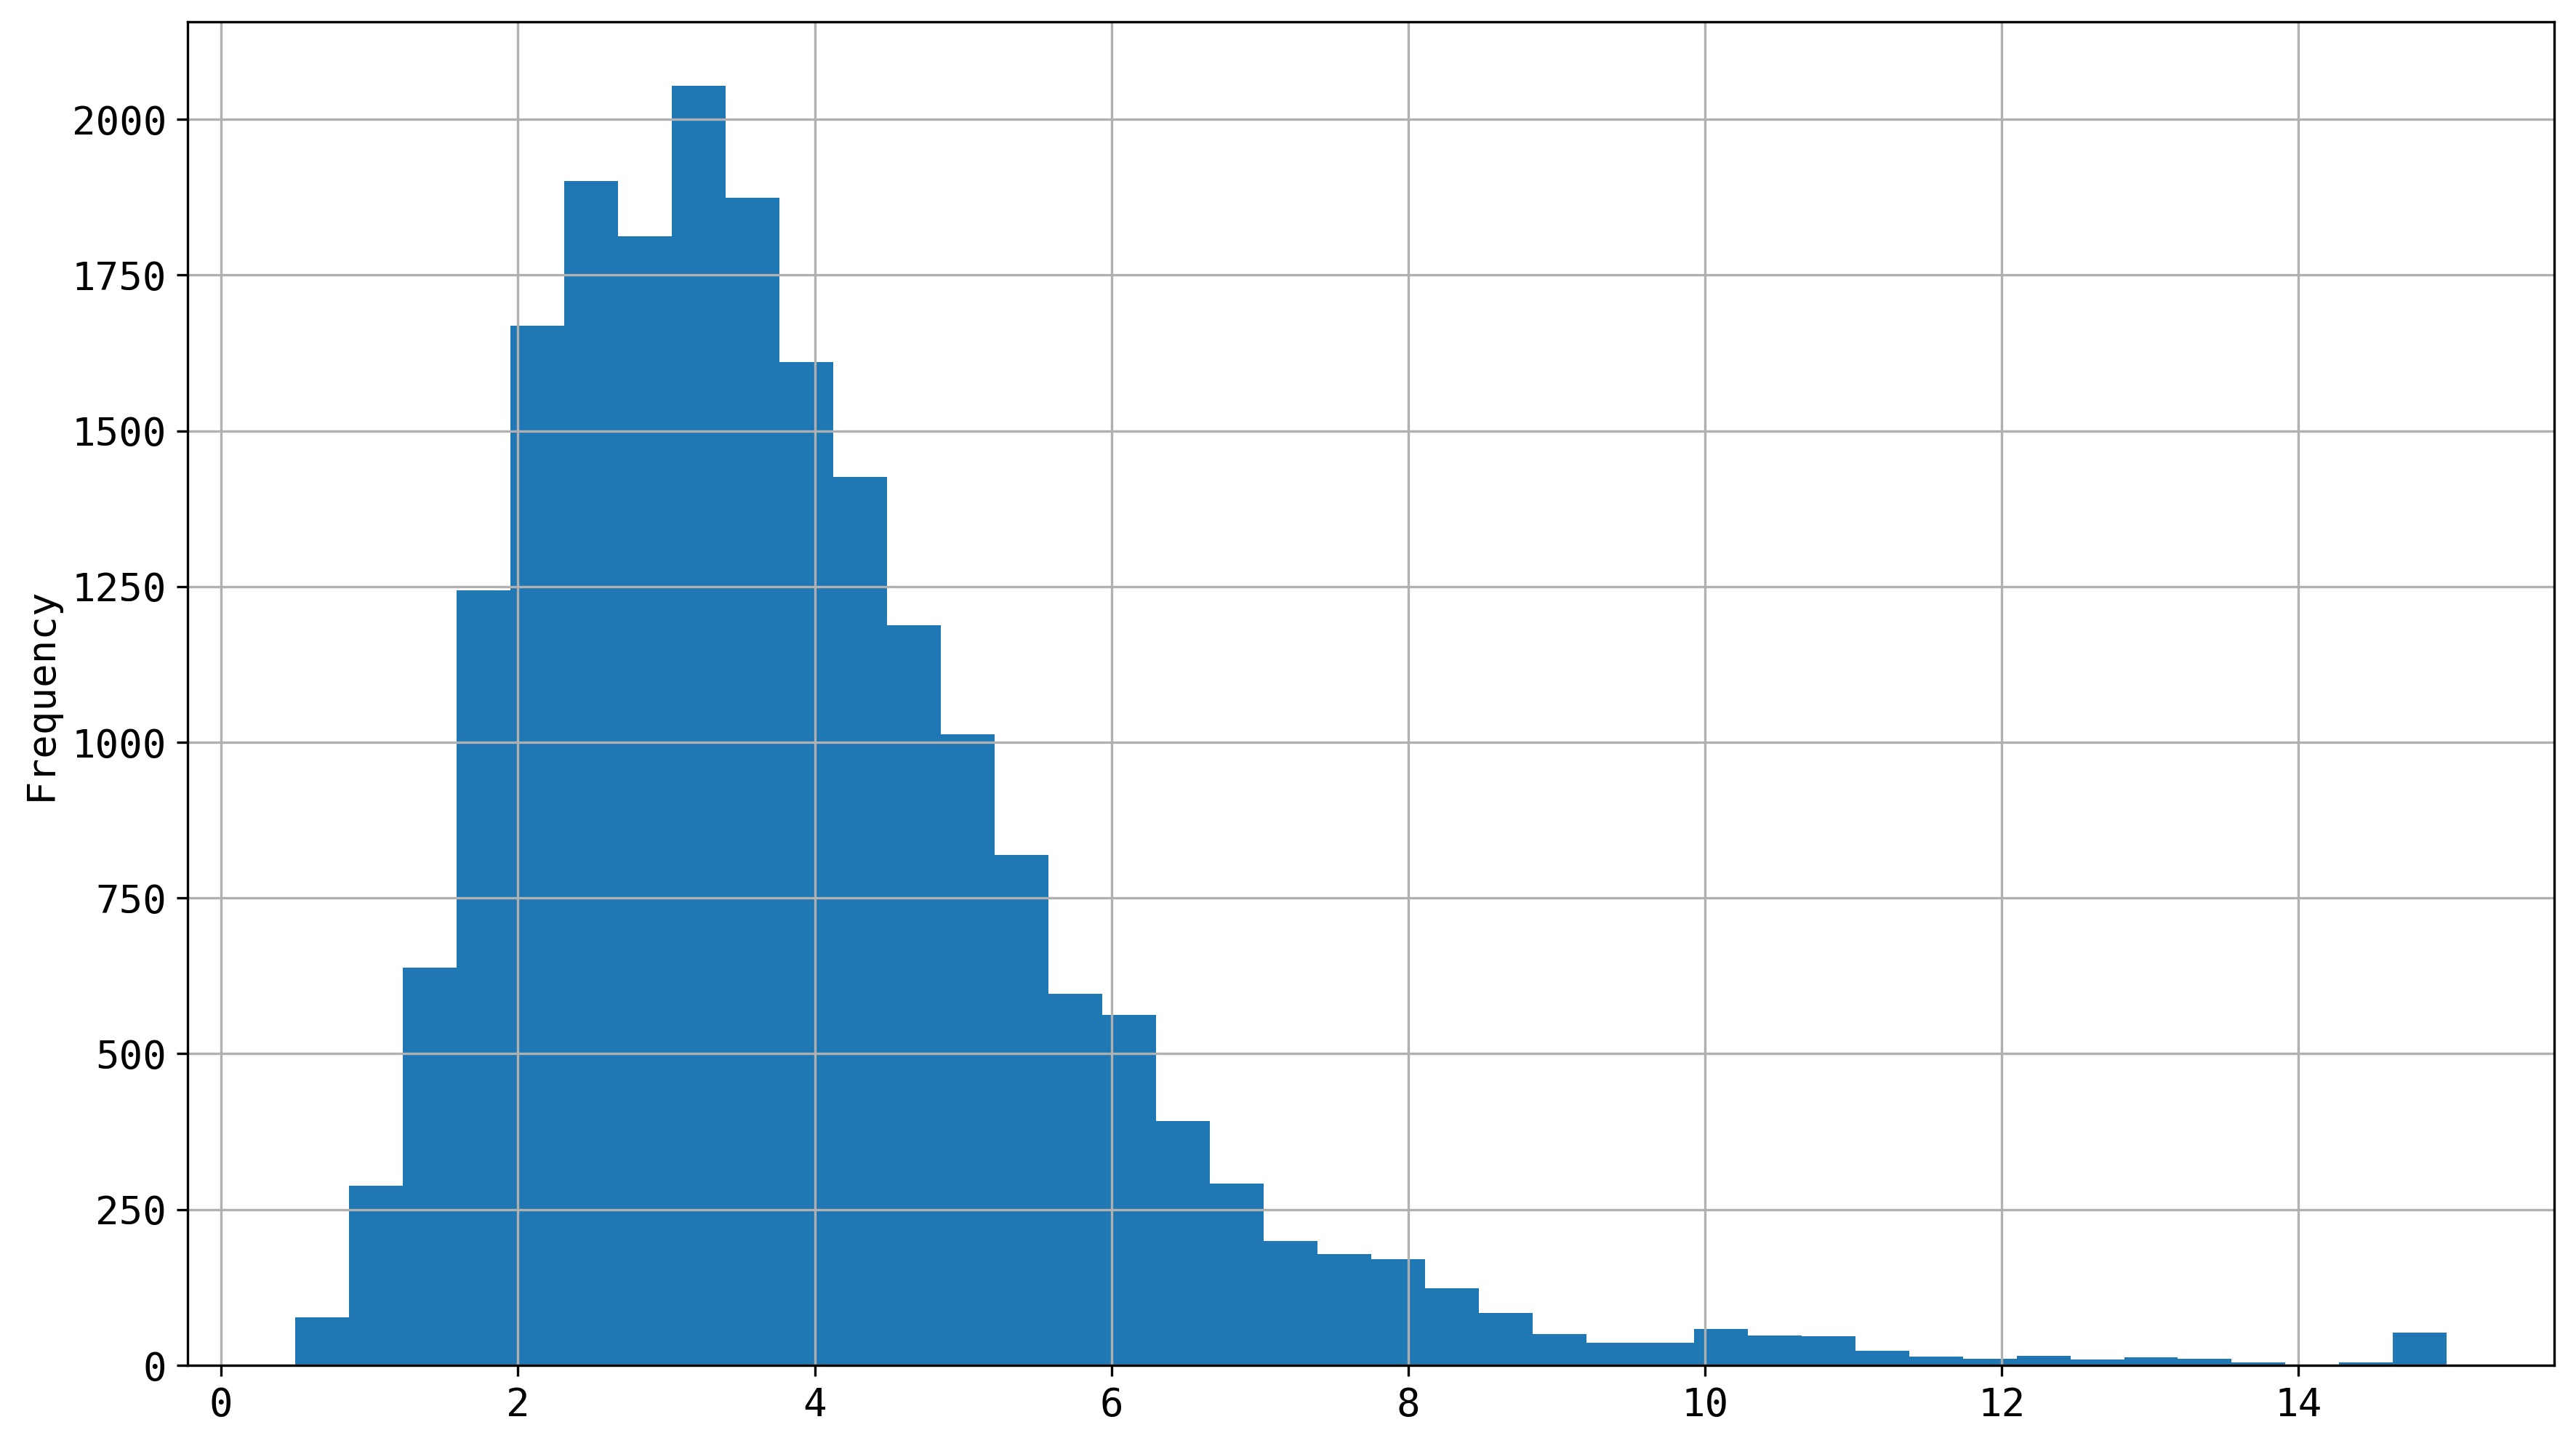

In [9]:
# visualize the median_income 

housing_num.median_income.plot.hist(bins=40, grid=True)

In [10]:
# subdivide into 5 categories

bins = [0., 1.5, 3.0, 4.5, 6.0, np.inf]

housing_num['income_cat'] = pd.cut(housing_num["median_income"],
                                   bins=bins, labels=[1, 2, 3, 4, 5])

housing_num.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value income_cat  
0       322.0       126.0         8.3252            452600.0          5  
1      2401.0      1138.0         8.3014            358500.0          5  
2       496.0       177.0         7.2574            352100.0          5  
3       558.0       219.0         5.6431            341300.0          4  
4       565.0       259.0         3.8462            342200.0          3

In [11]:
# get the ratio of the category in the dataset

housing_num.income_cat.value_counts().sort_values(ascending=False)/ len(housing_num)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

Split the dataset into a test set representative of the dataset in order to avoid sampling bias

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# use all the dataset instead of removing the non-numnerical attributes; as was done above

bins = [0., 1.5, 3.0, 4.5, 6.0, np.inf]

housing['income_cat'] = pd.cut(housing["median_income"],
                                   bins=bins, labels=[1, 2, 3, 4, 5])

In [14]:
# get the test dataset using this category

train_set, test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], shuffle=True)

print(len(train_set), len(test_set))

16512 4128


We want to confirm that the resulting test set is representative of the entire dataset so as to avoid sampling bias

In [15]:
# get the ratio and compare for any sample bias

test_set.income_cat.value_counts().sort_values(ascending=False) / len(test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

### **EXPLORATORY DATA ANALYSIS - EDA**

We can start to explore the training set now

In [16]:
# get a copy of the training set

housing = train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

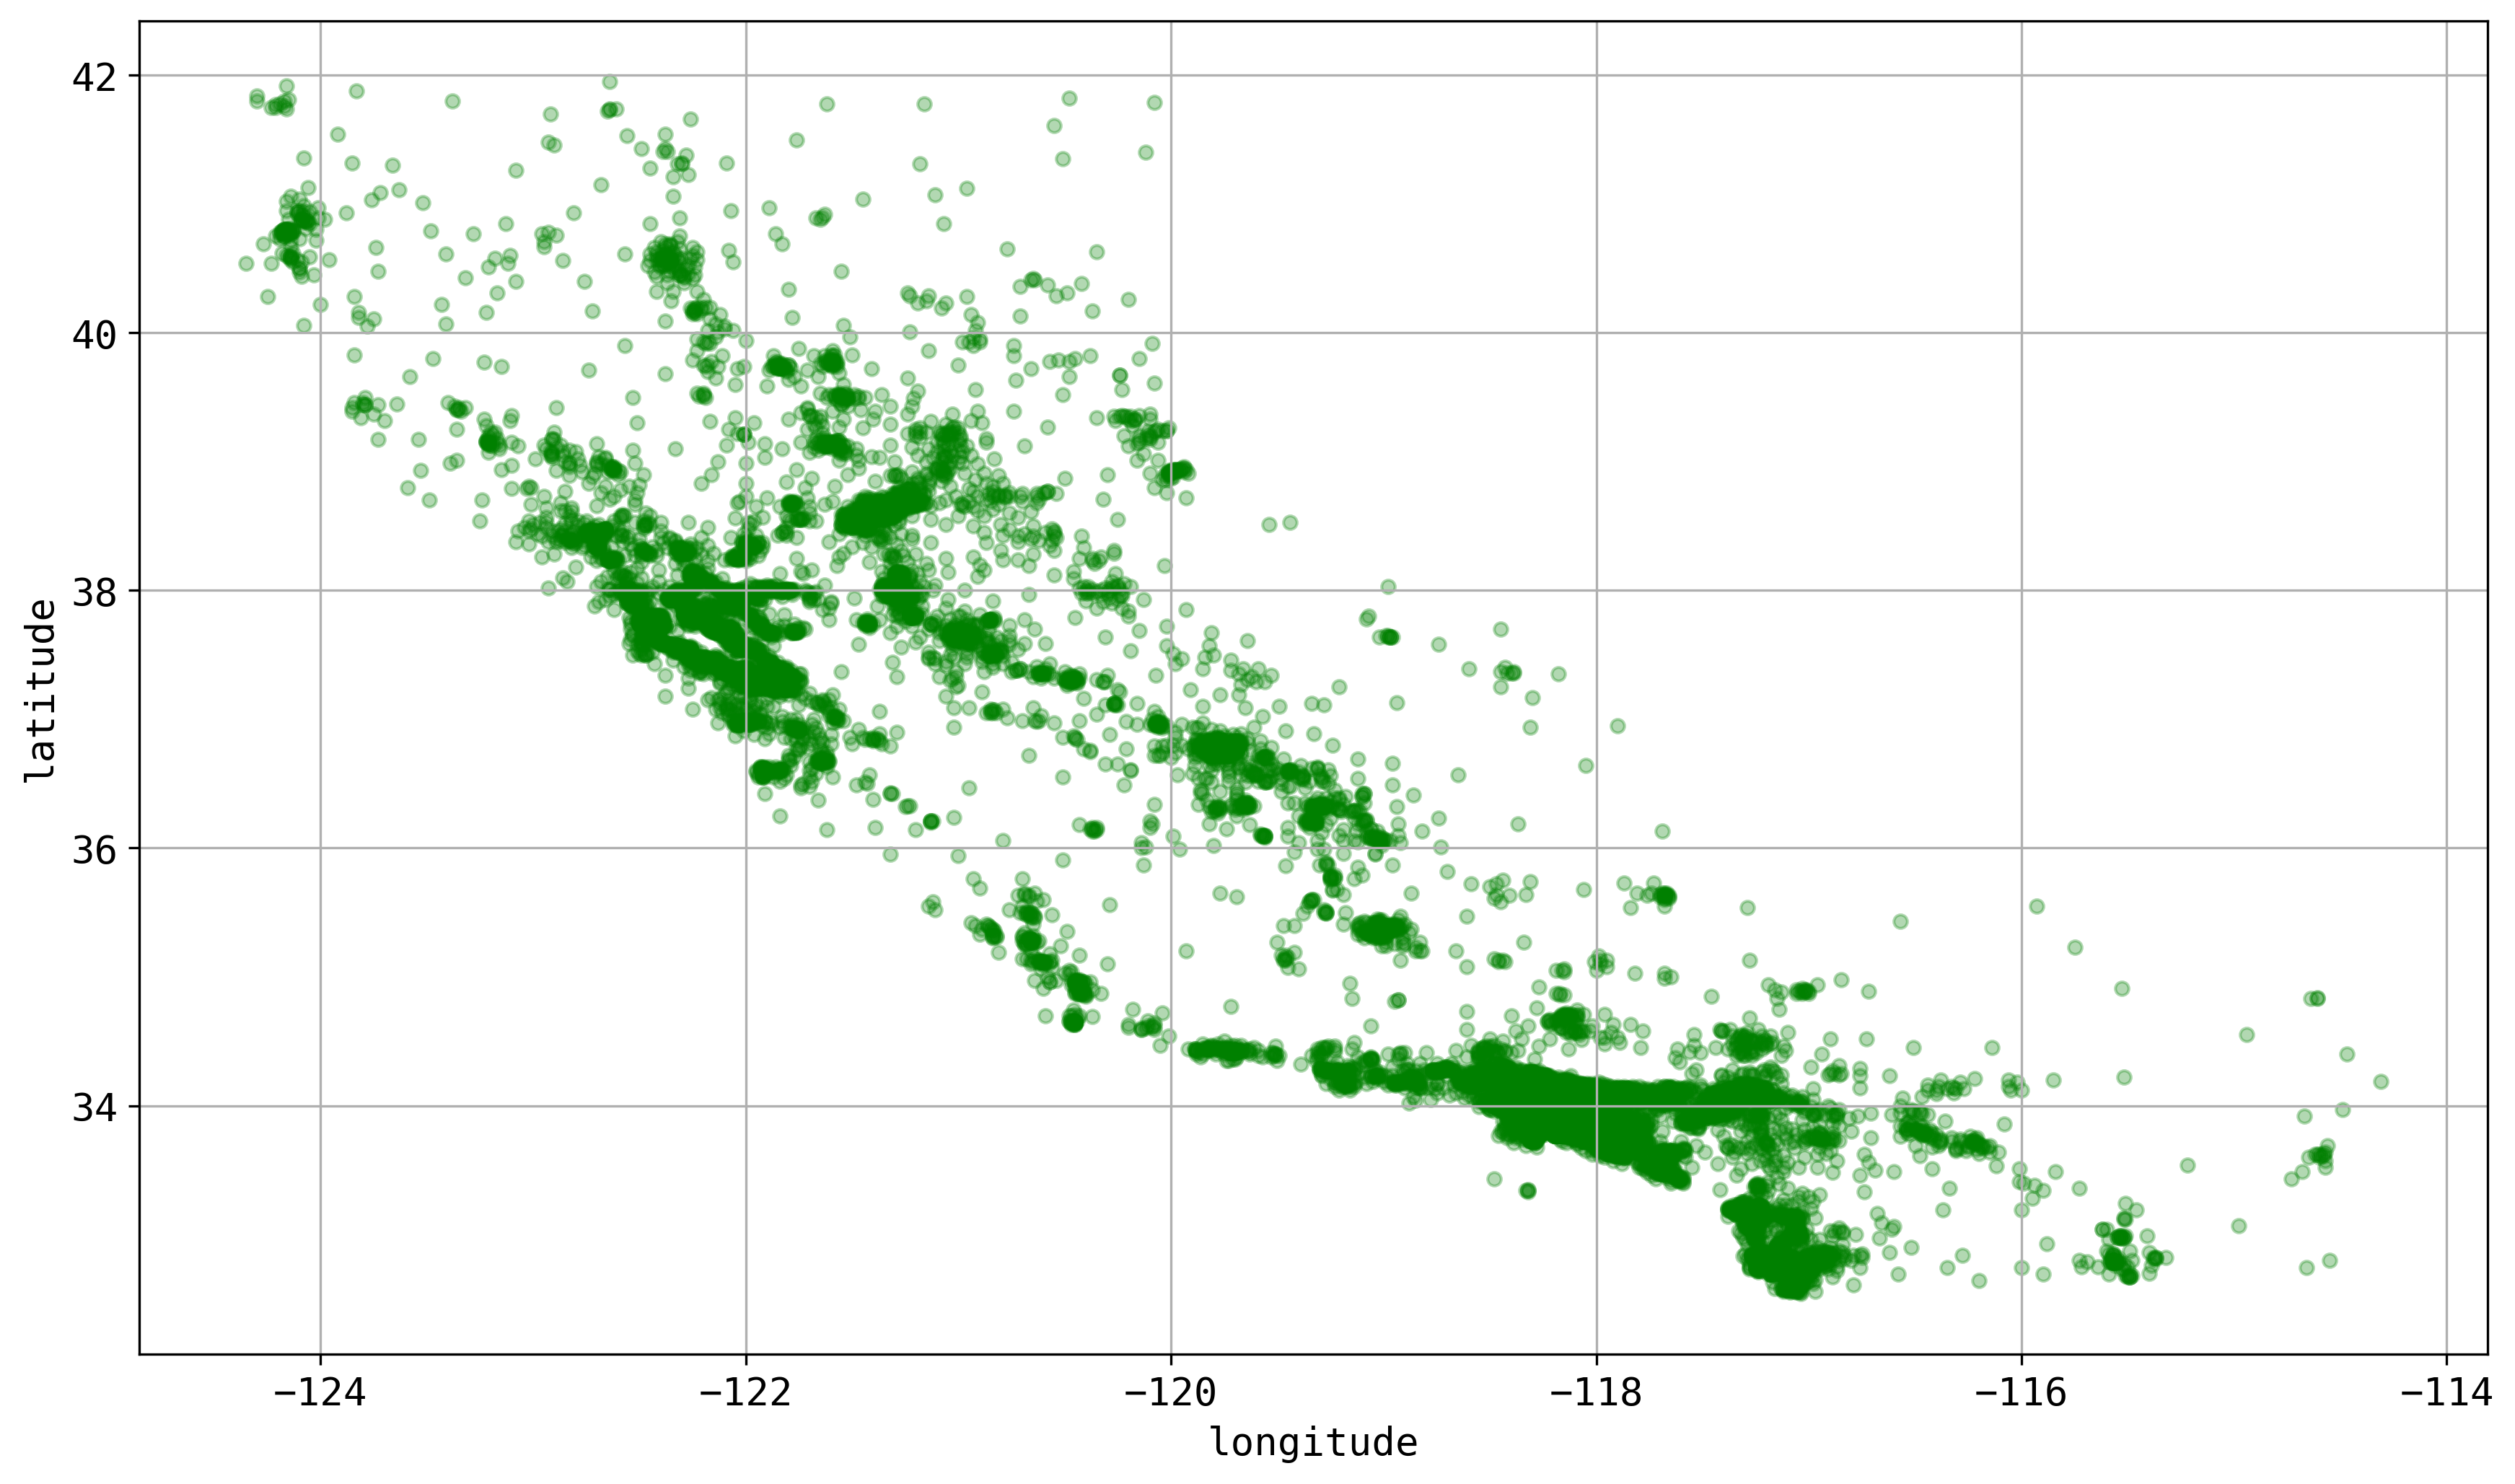

In [17]:
# visualise the geographical data

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.3, color='green', grid=True)

<Axes: xlabel='longitude', ylabel='latitude'>

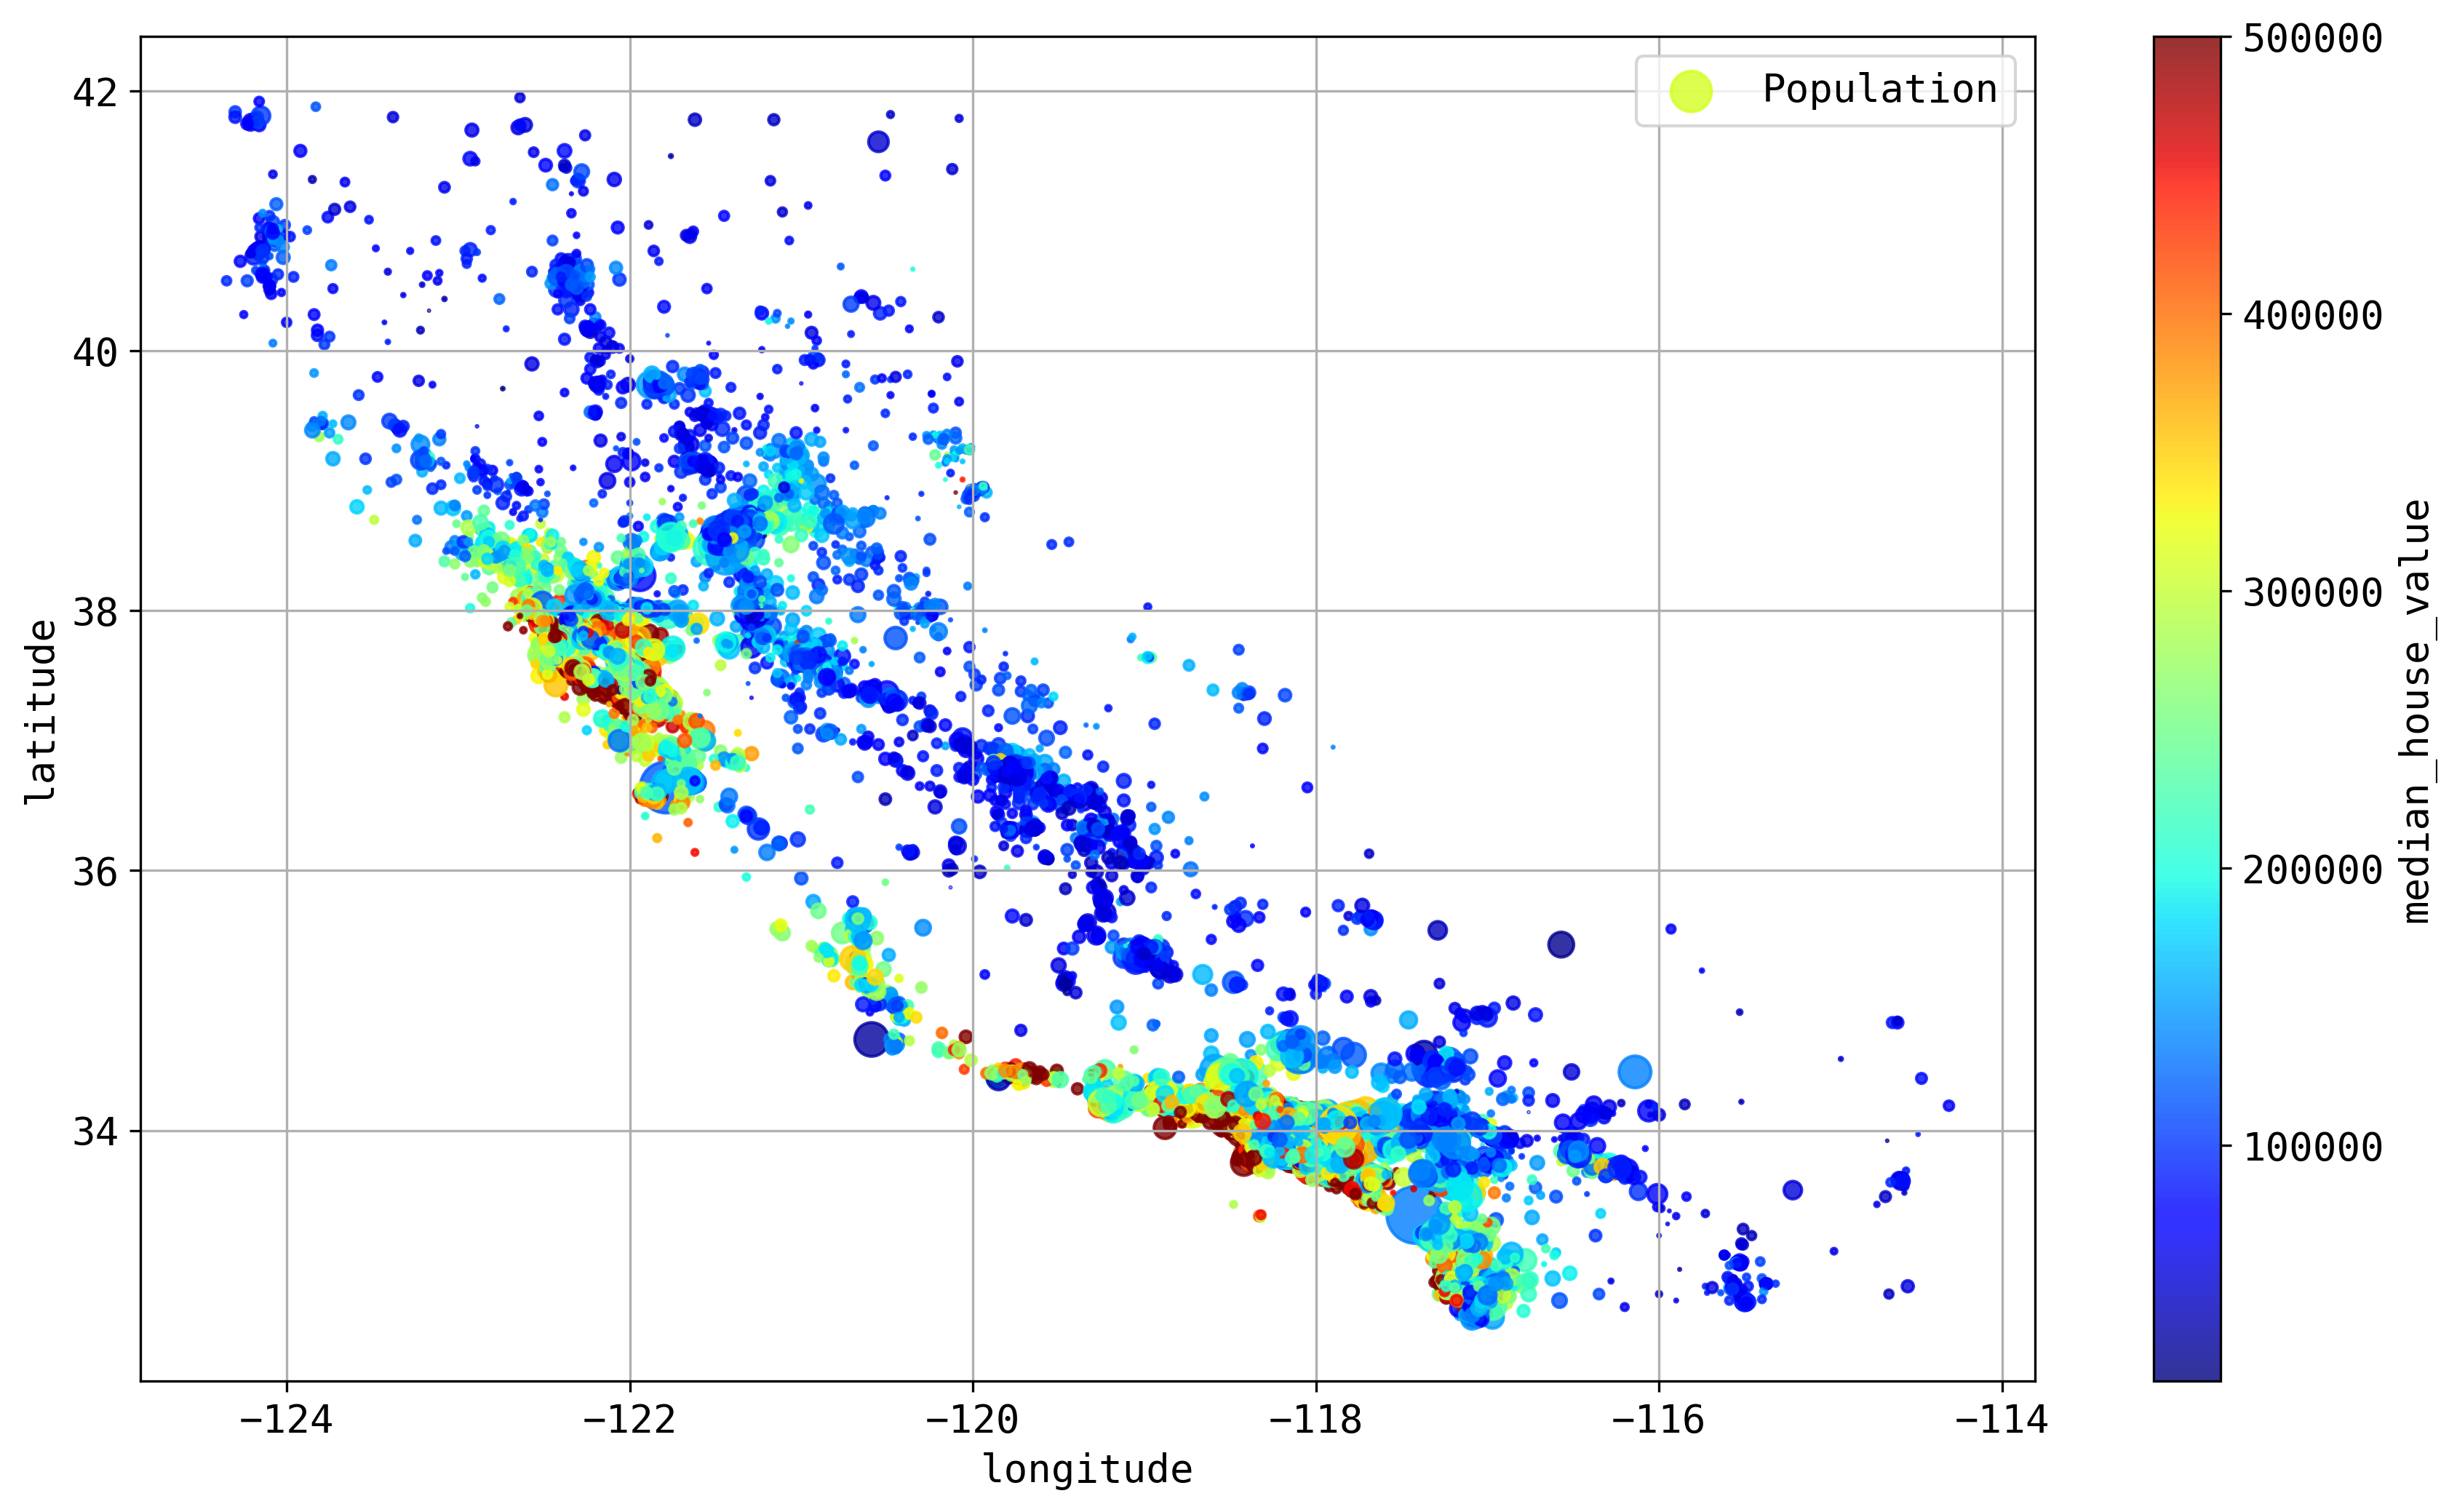

In [18]:
# add the population and households

housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    s=housing['population'] / 100,
    label='Population',
    c='median_house_value',
    colorbar=True,
    cmap='jet',
    grid=True,
    alpha=0.8, 
    legend=True, 
    sharex=False)

In [19]:
from pandas.plotting import scatter_matrix

array([[<Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housing_median_age'>,
        <Axes: xlabel='median_house_value', ylabel='housi

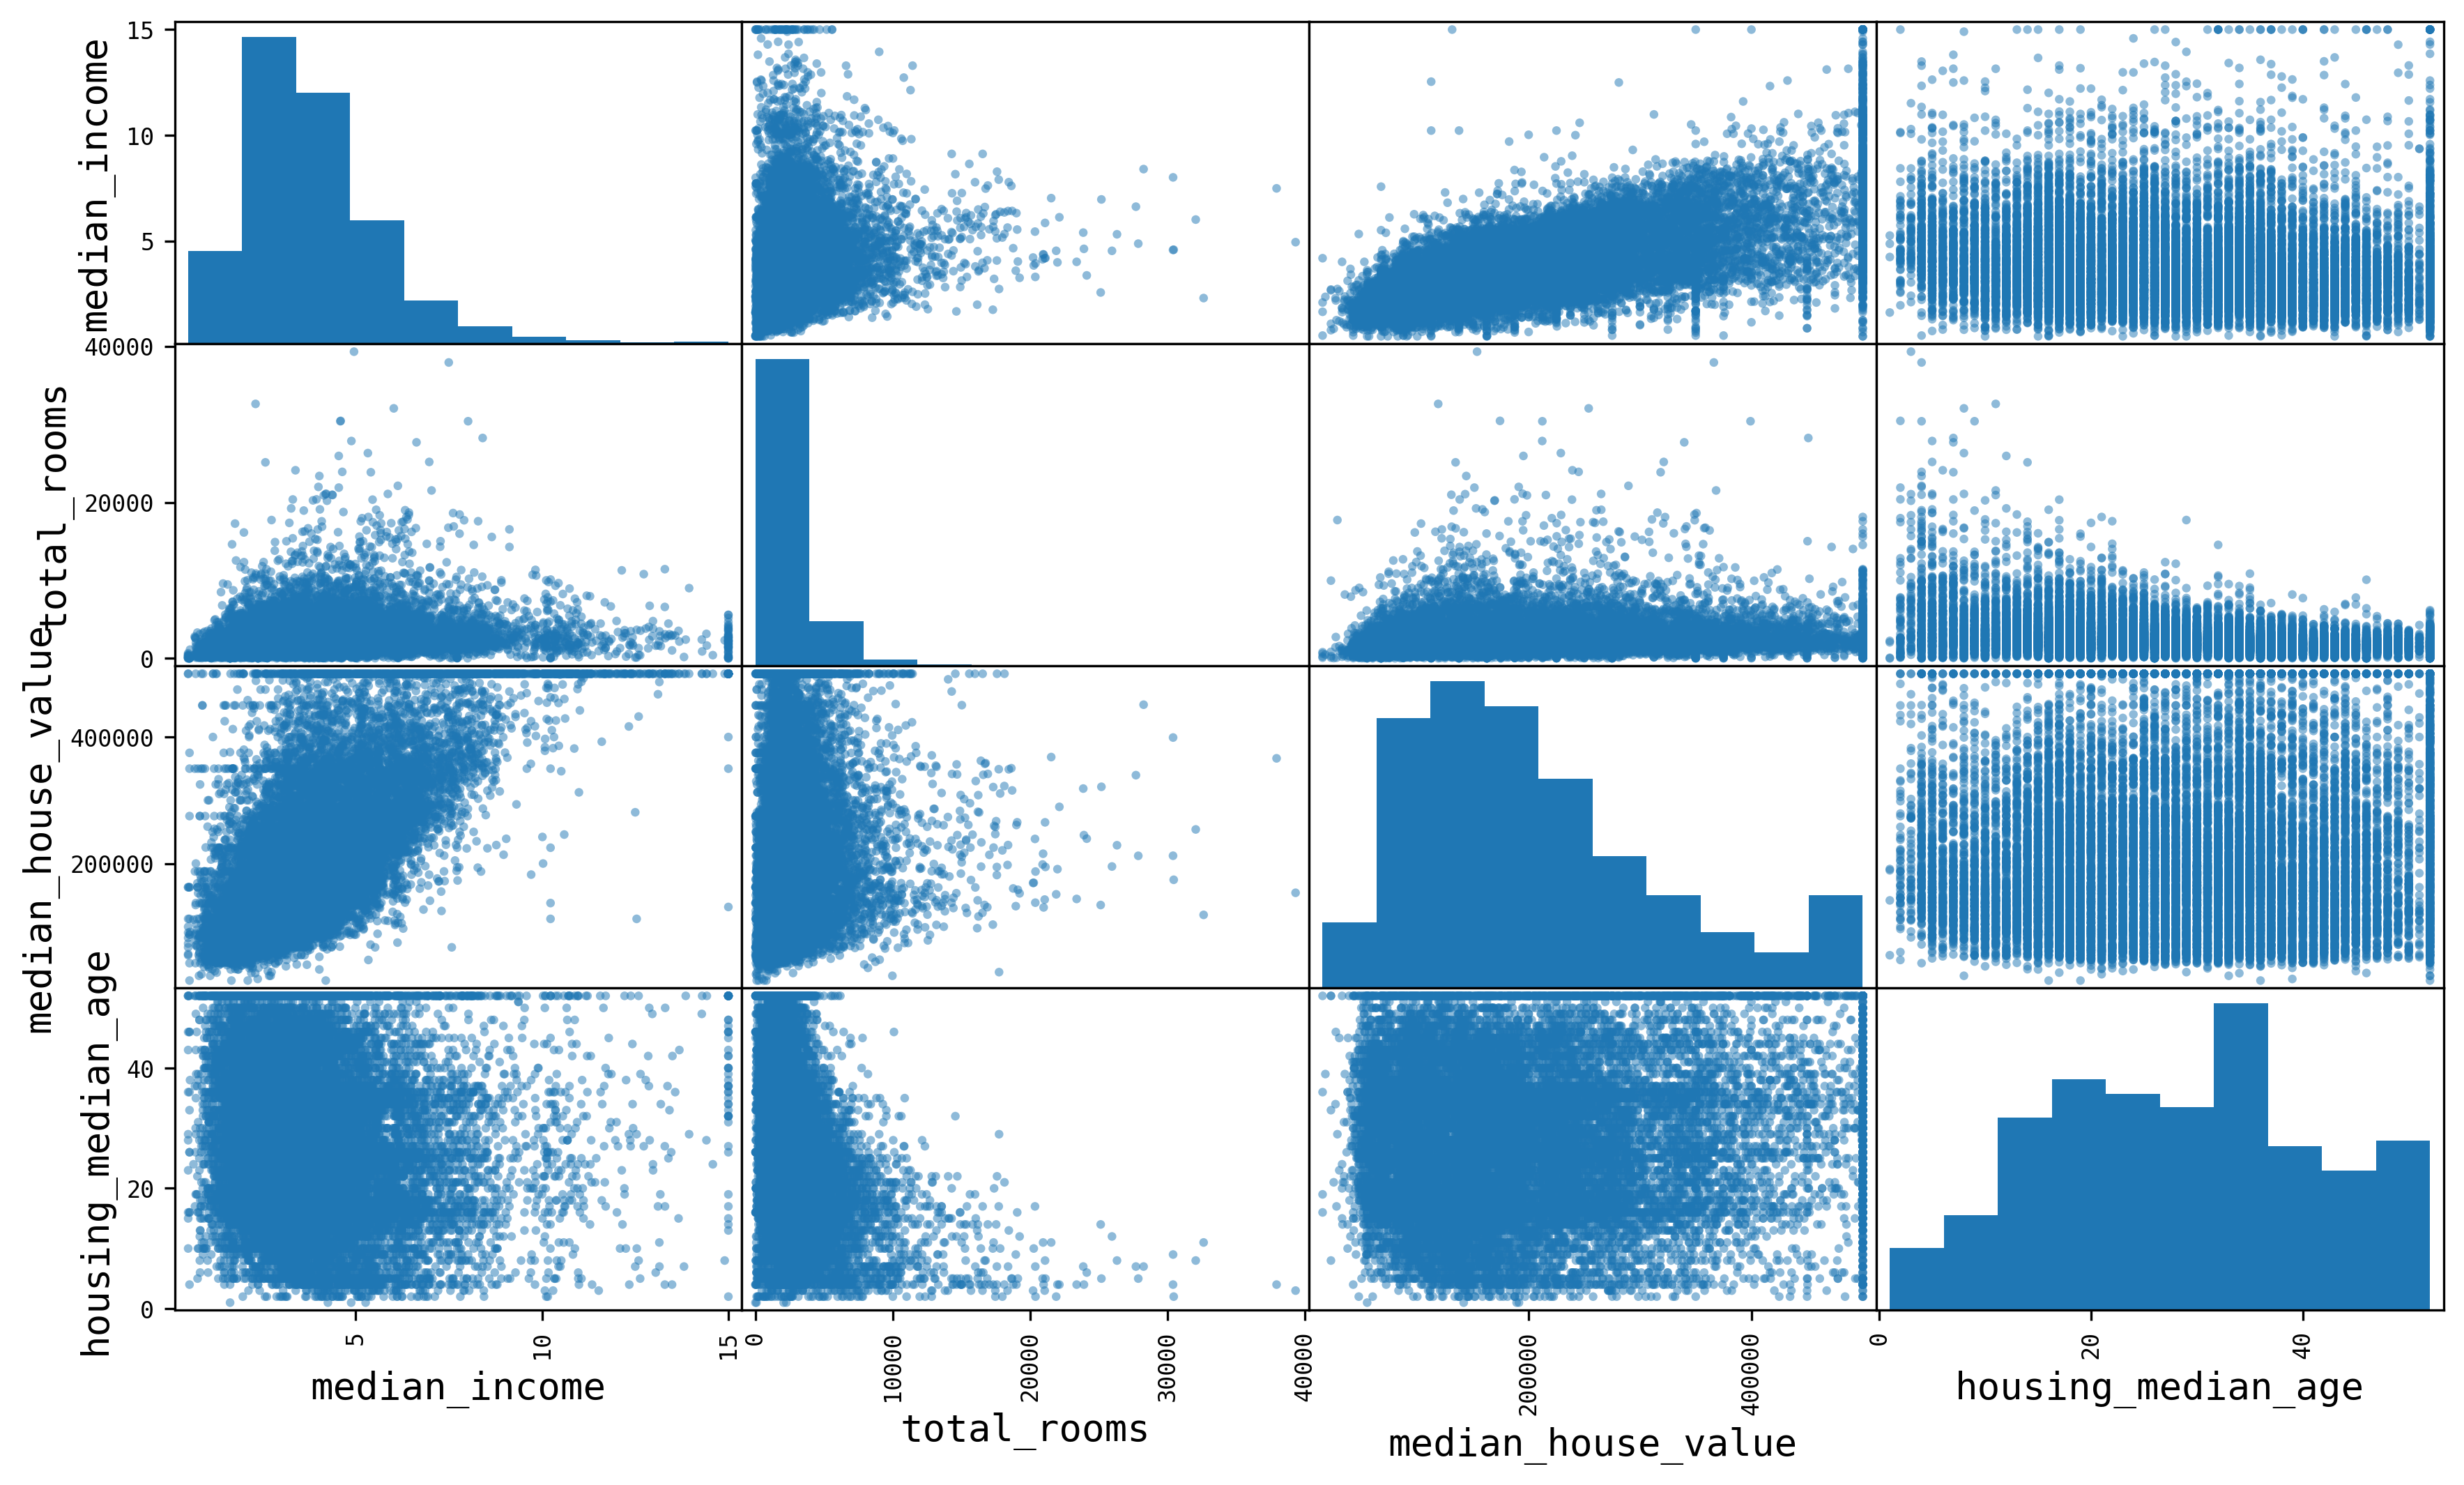

In [20]:
attr = ['median_income', 'total_rooms', 'median_house_value', 'housing_median_age']

scatter_matrix(housing_num[attr])

### **OBSERVATION - 4**

- median income remains the most correlated attributes

- there are quirkiness in the plot, and if not removed the model will learn this quirkiness
  
  - the plot indicates that there is an upper limit to *median_house_value* as *median_income* increases at $500k, ~$450k, ~$350, ~$280, ~$220k, ~$190, ~$170k, ~$140k. But this is untrue. 

> **NOTE: removing this datapoints will produce an even better model**

<Axes: xlabel='median_income', ylabel='median_house_value'>

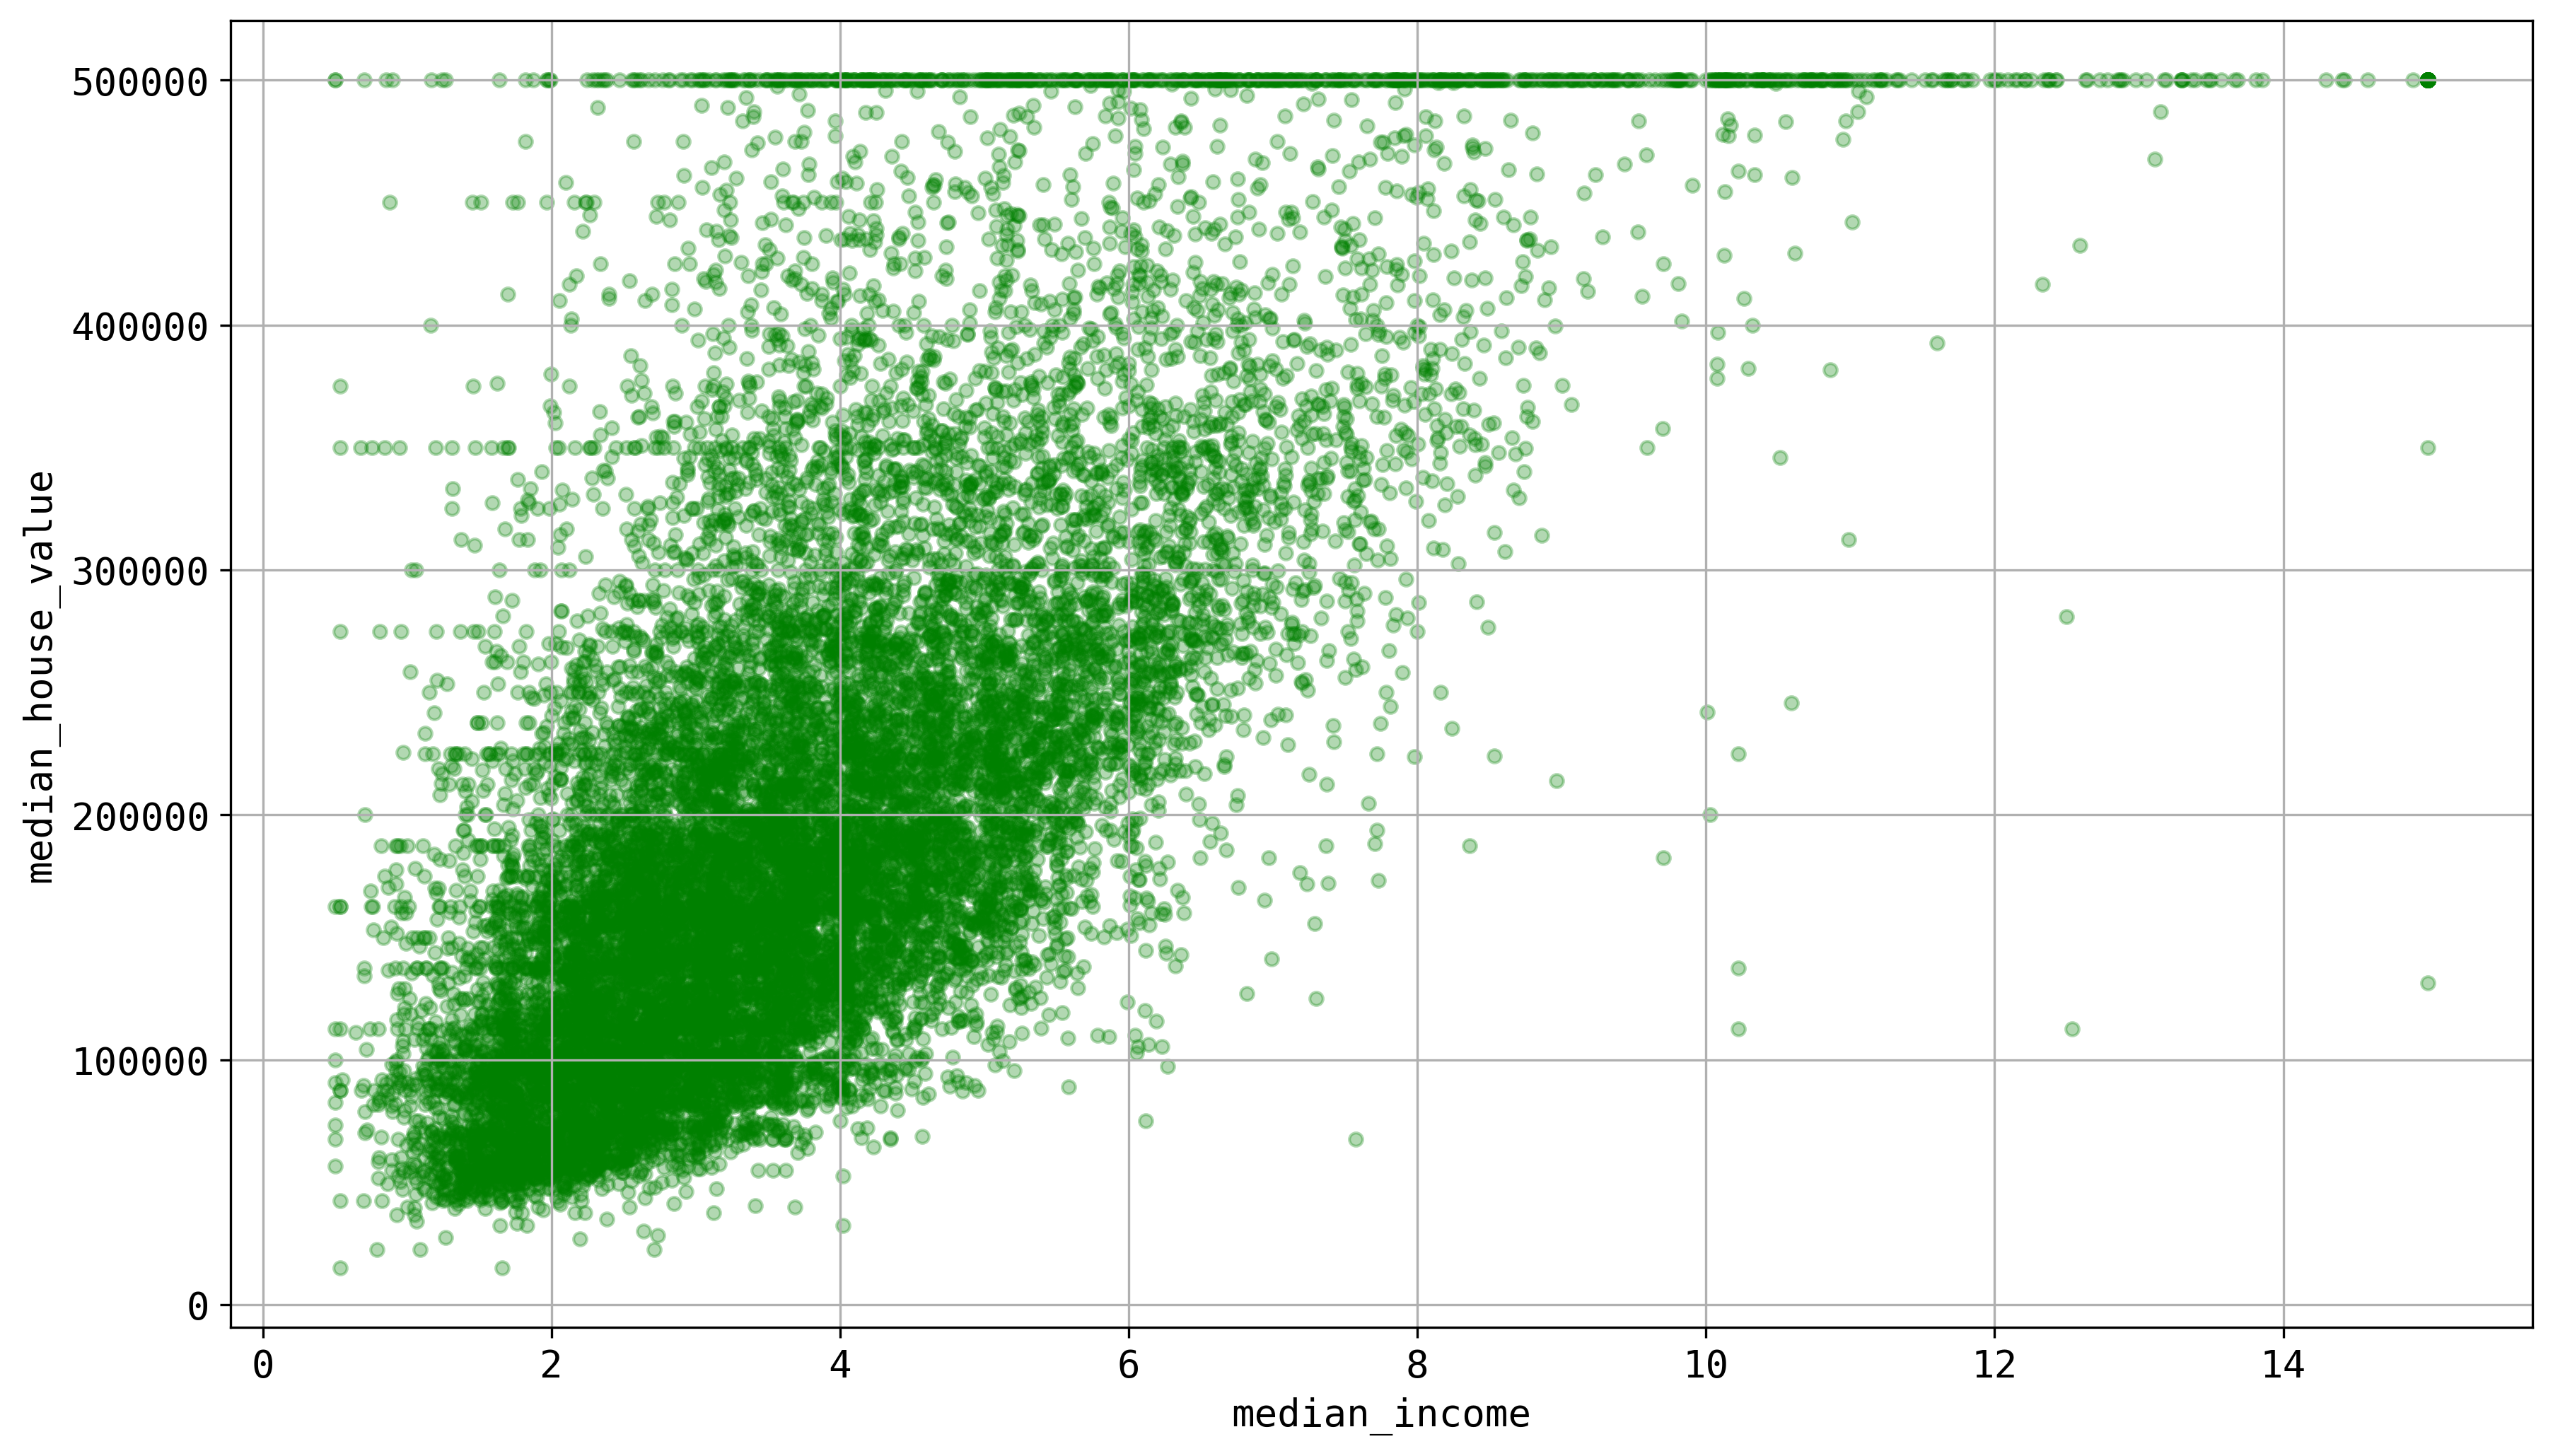

In [21]:
housing.plot(kind='scatter', y='median_house_value', x='median_income', alpha=0.3, color='green', grid=True)

### **EXPERIMENT WITH ATTRIBUTE COMBINATION**

Sometimes, combining attribute through mathematical transformation may produce a better correlation with the target values

In [22]:
# get the numerical attributes

housing_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'income_cat'],
      dtype='object')

In [23]:
# total room to bedroom ratio

housing_num['total_room_to_bedroom_ratio'] = housing_num['total_rooms'] / housing_num['total_bedrooms']

# total room per person
housing_num['room_to_person_ratio'] = housing_num['total_rooms'] / housing_num['households']

# house_value to bedrooms ratio

housing_num['bedrooms_to_household'] = housing_num['total_bedrooms'] / housing_num['households']

In [24]:
# compute the correlation matrix

corr_mat = housing_num.corr()

corr_mat['median_house_value'].sort_values(ascending=False)

median_house_value             1.000000
median_income                  0.688075
income_cat                     0.643892
total_room_to_bedroom_ratio    0.383920
room_to_person_ratio           0.151948
total_rooms                    0.134153
housing_median_age             0.105623
households                     0.065843
total_bedrooms                 0.049686
population                    -0.024650
longitude                     -0.045967
bedrooms_to_household         -0.046739
latitude                      -0.144160
Name: median_house_value, dtype: float64

#### **OBSERVATION - 5**

The combination yielded a better linear correlation than the stand alone attributes.For example, the ***total_room_to_bedroom_ratio*** yielded a better correlation than ***total_rooms*** or ***total_bedrooms***

## **PREPARING DATA FOR MACHINE LEARNING**

- get a copy of the data

- drop the target value

- Clean the data

- Standardize or normalize the dataset

- perform necessary transformation; by creating a transformation pipeline is necessary

In [53]:
# get a copy of the training set and drop the target attribute

# the drop method returns a copy of the dataframe/series
housing = train_set.drop(["median_house_value", "income_cat"], axis=1)

# get the label data
housing_labels = train_set["median_house_value"].copy()

In [54]:
# clean the data and transform missing values

housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 18488 to 5833
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16352 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [27]:
# replace the  missing values in total bedrooms with the median value

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [28]:
housing_num = housing.select_dtypes(include=[np.number])

**FIT** method will learn the value that will be used in each column; so that when the **TRANSFORM** is invoked, the ***learned values*** can be used in the dataset, wherever necessary.

In [29]:
# fit the training set to the estimator

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [30]:
X = imputer.transform(housing_num)

### **NOTE**

The **TRANSFORM** method, by default, will return a **Numpy** array instead of a **DataFrame**.

This can be modified by setting the returned transformed values to a dataframe, or explicitly converting the result to a DataFrame, as shown below. 

In [31]:
X

array([[-1.2159e+02,  3.6970e+01,  1.6000e+01, ...,  4.0300e+02,
         1.3000e+02,  5.7396e+00],
       [-1.2094e+02,  3.7590e+01,  1.6000e+01, ...,  2.6220e+03,
         7.6600e+02,  2.3152e+00],
       [-1.1822e+02,  3.3980e+01,  3.4000e+01, ...,  2.9800e+03,
         7.3600e+02,  1.6685e+00],
       ...,
       [-1.1695e+02,  3.2820e+01,  1.8000e+01, ...,  1.9040e+03,
         5.9500e+02,  3.8024e+00],
       [-1.1843e+02,  3.3980e+01,  1.9000e+01, ...,  2.9270e+03,
         1.5380e+03,  7.5426e+00],
       [-1.1832e+02,  3.4200e+01,  3.6000e+01, ...,  8.3400e+02,
         3.1100e+02,  3.9866e+00]])

In [32]:
# convert the trained set X to a Dataframe

housing_trained = pd.DataFrame(X, columns=imputer.get_feature_names_out(), index=housing_num.index)

housing_trained.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
18488    -121.59     36.97                16.0        865.0           123.0   
19571    -120.94     37.59                16.0       3964.0           824.0   
7292     -118.22     33.98                34.0       2225.0           753.0   
3721     -118.43     34.20                28.0       3386.0           435.0   
5568     -118.29     33.88                32.0       2307.0           493.0   

       population  households  median_income  
18488       403.0       130.0         5.7396  
19571      2622.0       766.0         2.3152  
7292       2980.0       736.0         1.6685  
3721       2240.0       737.0         3.0221  
5568       1754.0       528.0         4.3170

## **Data Transformation Pipeline**

- Perform imputation on the numerical attributes using the median

- Perform imputation on the categorical attributes using the most frequent data point

- Standardize the numerical features so that they have a mean of 0 and standard deviation of 1.

- Encode the categorical feature `ocean_proximity` using the **ONE-HOT** encoding scheme

In [33]:
# create the transformation Pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

In [34]:
# this pipeline would behave like a transformer since...
# the last estimator is a transformer


numerical_pipeline = Pipeline(
    steps=[
        ("simple-impute", SimpleImputer(strategy="median")),
        ("scaling", StandardScaler())])

# this pipeline would also behave like a transformer since...
# the last estimator is a transformer
categorical_pipeline = Pipeline(
    steps=[
        ('cat-simple-impute', SimpleImputer(strategy="most_frequent")),
        ("1hot-encoding", OneHotEncoder(handle_unknown="ignore"))])

In [35]:
# create the column transformer to handle the attribute in one step

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

In [36]:
# create a transformer that will handle both classes of attributes

preprocessing = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, make_column_selector(dtype_include=np.number)),
        ("cat", categorical_pipeline, make_column_selector(dtype_include=object))])
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simple-impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaling',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc42ab165a0>),
                                ('cat',
                                 Pipeline(steps=[('cat-simple-impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('1hot-encoding',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc428bfd520>)])

In [55]:
housing = train_set.copy().drop(["income_cat", "median_house_value"], axis=1)

housing

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
18488    -121.59     36.97                16.0        865.0           123.0   
19571    -120.94     37.59                16.0       3964.0           824.0   
7292     -118.22     33.98                34.0       2225.0           753.0   
3721     -118.43     34.20                28.0       3386.0             NaN   
5568     -118.29     33.88                32.0       2307.0           493.0   
...          ...       ...                 ...          ...             ...   
7653     -118.27     33.83                34.0       1124.0           245.0   
19766    -122.10     40.03                25.0       2516.0             NaN   
15100    -116.95     32.82                18.0       3038.0           592.0   
5502     -118.43     33.98                19.0       8324.0          1590.0   
5833     -118.32     34.20                36.0       1978.0           337.0   

       population  households  median_income ocean_proximity  
18488       403.0       130.0         5.7396          INLAND  
19571      2622.0       766.0         2.3152          INLAND  
7292       2980.0       736.0         1.6685       <1H OCEAN  
3721       2240.0       737.0         3.0221       <1H OCEAN  
5568       1754.0       528.0         4.3170       <1H OCEAN  
...           ...         ...            ...             ...  
7653        717.0       242.0         3.1667       <1H OCEAN  
19766      1266.0       494.0         1.7566          INLAND  
15100      1904.0       595.0         3.8024       <1H OCEAN  
5502       2927.0      1538.0         7.5426       <1H OCEAN  
5833        834.0       311.0         3.9866       <1H OCEAN  

[16512 rows x 9 columns]

In [38]:
# apply the transformation on housing dataset

housing_prepared = preprocessing.fit_transform(housing)

df_housing_prepared = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index=housing.index)

df_housing_prepared

num__longitude  num__latitude  num__housing_median_age  \
18488       -1.002777       0.624212                -1.008626   
19571       -0.678720       0.914497                -1.008626   
7292         0.677332      -0.775711                 0.424664   
3721         0.572637      -0.672707                -0.053099   
5568         0.642434      -0.822531                 0.265410   
...               ...            ...                      ...   
7653         0.652405      -0.845941                 0.424664   
19766       -1.257037       2.056909                -0.291981   
15100        1.310489      -1.318825                -0.849372   
5502         0.572637      -0.775711                -0.769744   
5833         0.627478      -0.672707                 0.583919   

       num__total_rooms  num__total_bedrooms  num__population  \
18488         -0.803616            -0.978454        -0.894039   
19571          0.604851             0.678161         1.043512   
7292          -0.185508             0.510373         1.356105   
3721           0.342156            -0.241130         0.709964   
5568          -0.148240            -0.104064         0.285606   
...                 ...                  ...              ...   
7653          -0.685903            -0.690142        -0.619865   
19766         -0.053251            -0.241130        -0.140498   
15100          0.183993             0.129895         0.416580   
5502           2.586432             2.488386         1.309827   
5833          -0.297768            -0.472726        -0.517705   

       num__households  num__median_income  num__median_house_value  \
18488        -0.959608            0.985048                 0.879229   
19571         0.690188           -0.819680                -0.830260   
7292          0.612367           -1.160503                -0.678710   
3721          0.614961           -0.447129                 0.718153   
5568          0.072811            0.235309                 0.221933   
...                ...                 ...                      ...   
7653         -0.669078           -0.370922                -0.175562   
19766        -0.015385           -1.114073                -1.288376   
15100         0.246611           -0.035895                -0.539283   
5502          2.692769            1.935265                 1.251611   
5833         -0.490090            0.061182                 0.755391   

       cat__ocean_proximity_<1H OCEAN  cat__ocean_proximity_INLAND  \
18488                             0.0                          1.0   
19571                             0.0                          1.0   
7292                              1.0                          0.0   
3721                              1.0                          0.0   
5568                              1.0                          0.0   
...                               ...                          ...   
7653                              1.0                          0.0   
19766                             0.0                          1.0   
15100                             1.0                          0.0   
5502                              1.0                          0.0   
5833                              1.0                          0.0   

       cat__ocean_proximity_ISLAND  cat__ocean_proximity_NEAR BAY  \
18488                          0.0                            0.0   
19571                          0.0                            0.0   
7292                           0.0                            0.0   
3721                           0.0                            0.0   
5568                           0.0                            0.0   
...                            ...                            ...   
7653                           0.0                            0.0   
19766                          0.0                            0.0   
15100                          0.0                            0.0   
5502                           0.0                           

## **CLUSTER SIMILARITY SEARCH**

We would like to see if there are clusters within the dataset, and then use a radial basis function to determine how (similar) close or far (a distance measurement) each datapoints are from each cluster centers. 

The distance measurement is that of the cluster centers from the `longitude` and `latitude`.

**PROCEDURES**

1. **FIT** a *KMeans algorithm* to the dataset to determine the `cluster centers`.

2. **TRANSFORM** the dataset using a *gaussian radial basis function*, where the *fixed point would be the cluster centers*, and the `decay rate; gamma = 1.0`


Since this is not a stateless transformation (learned parameters; cluster centers are needed), then we can instead implement a custom transformer

In [39]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.base import check_array, check_is_fitted

In [40]:
class ClusterSimilaritySearch(BaseEstimator, TransformerMixin):
    """
    This performs a similarity meassurement, by using a clustering algorithm to determine the cluster centers, and then a scaled distance measurement, of the distance of each datapoints from the fixed cluster centers is computed through the gaussian radial basis function.

    The parameters to an instance is;

    n_clusters: int| determines the number of clustering centers
    gamma: float| determines the decay rate
    random_state: int| determines the reproducibility of the clustering algorithm
    """

    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        """Instantiates using the decay rate; gamma, number of clusters; n_clusters and KMeans random state for reproducibility; random_state"""

        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        """fit KMeans algorithm to the X, and save the cluster centers, as the learned parameters"""

        # check that it contains finite float only
        # check_array(X)

        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)

        if type(sample_weight) == "numpy.ndarray":
            sample_weight = sample_weight.to_numpy()

        self.kmeans_.fit(X, sample_weight=sample_weight)

        # self.feature_names_in_ = X.shape[1]
        return self     # always return self

    def transform(self, X):
        """Transform the data using the radial basis kernel function, where the fixed point(s) are the cluster center(s)"""

        # check X contains finite floats
        # check_array(X)

        # check that X is fitted
        # check_is_fitted(X)

        cluster_center_Y = self.kmeans_.cluster_centers_
        
        return rbf_kernel(X, cluster_center_Y, gamma=self.gamma)

    def get_feature_names_out(self, names=None):

        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]        

### **TRANSFORMATION PIPELINE**

Here we define all the transformation on our dataset at once

In [41]:
from sklearn.pipeline import FunctionTransformer


def column_ratio(X):
    """takes a 2D-numpy array, with 2 columns, and divide the first columns using the second column"""
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    """This function takes two input parameters, used by the get_feature_names_out function. Where the first parameter must be the function transformer itself, and the second parameter is the feature names passed into the transformer.

    In this case however, they are not used, they are there for the sake of satisfying the API
    """
    return ["ratio"]

def ratio_pipeline():
    """construct a new feature whose values are from the ratio of two specified features"""
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_similarity = ClusterSimilaritySearch(n_clusters=10, gamma=1.0, random_state=42)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())

In [60]:
preprocessing = ColumnTransformer(
    transformers=[
        ('bedrooms', ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
        ("geo", cluster_similarity, ["latitude", "longitude"]),
        ("cat", categorical_pipeline, make_column_selector(dtype_include=object))
        ],
    # the remainder is "median_house_age"
    remainder=default_num_pipeline)

In [61]:
housing_prepared = preprocessing.fit_transform(housing)

In [63]:
df_housing_prepared = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index=housing.index)

df_housing_prepared

bedrooms__ratio  rooms_per_house__ratio  people_per_house__ratio  \
18488        -1.083360                0.492737                 0.003868   
19571        -0.089780               -0.097360                 0.034667   
7292          1.885390               -0.955960                 0.094355   
3721         -1.291025               -0.329037                -0.001915   
5568         -0.001630               -0.418807                 0.025035   
...                ...                     ...                      ...   
7653          0.063032               -0.308956                -0.009214   
19766        -0.618949               -0.130006                -0.047363   
15100        -0.286543               -0.124912                 0.013404   
5502         -0.344806               -0.002680                -0.110264   
5833         -0.657064                0.375542                -0.036023   

       log__total_bedrooms  log__total_rooms  log__population  \
18488            -1.698496         -1.155868        -1.394956   
19571             0.909116          0.876616         1.148179   
7292              0.785582          0.105566         1.321980   
3721              0.033291          0.666189         0.934352   
5568              0.204889          0.153887         0.602226   
...                    ...               ...              ...   
7653             -0.753780         -0.806164        -0.612579   
19766             0.033291          0.269675         0.159480   
15100             0.455778          0.521391         0.713658   
5502              1.810296          1.867155         1.297611   
5833             -0.316673         -0.051542        -0.407313   

       log__households  log__median_income  geo__Cluster 0 similarity  \
18488        -1.523113            1.068291               3.146533e-04   
19571         0.901264           -0.860203               1.291002e-04   
7292          0.846654           -1.556010               5.496378e-02   
3721          0.848510           -0.294213               1.367400e-01   
5568          0.392664            0.463274               5.532987e-02   
...                ...                 ...                        ...   
7653         -0.673725           -0.194935               4.723490e-02   
19766         0.301683           -1.446712               8.290999e-15   
15100         0.555960            0.193661               8.958633e-06   
5502          1.854061            1.648558               9.645620e-02   
5833         -0.330834            0.294146               1.029747e-01   

       geo__Cluster 1 similarity  ...  geo__Cluster 6 similarity  \
18488               2.282933e-01  ...               1.655617e-02   
19571               1.299654e-01  ...               6.274491e-02   
7292                7.548278e-15  ...               1.511639e-04   
3721                2.201826e-13  ...               7.807260e-04   
5568                5.987590e-15  ...               1.068089e-04   
...                          ...  ...                        ...   
7653                3.385883e-15  ...               7.695136e-05   
19766               1.192275e-02  ...               1.552258e-08   
15100               1.193103e-24  ...               5.349444e-10   
5502                4.050984e-14  ...               2.579937e-04   
5833                9.232722e-14  ...               5.965786e-04   

       geo__Cluster 7 similarity  geo__Cluster 8 similarity  \
18488               2.767098e-09               8.282373e-01   
19571               2.449685e-09               3.305428e-01   
7292                9.954893e-01               2.556254e-11   
3721                9.452420e-01               4.645100e-10   
5568                9.760975e-01               2.207050e-11   
...                          ...                        ...   
7653                9.595957e-01               1.359745e-11   
19766               9.585014e-23               4.001429e-04   
15100               4.112413e-02               5.570619e-20   
5

In [64]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

<Axes: ylabel='Density'>

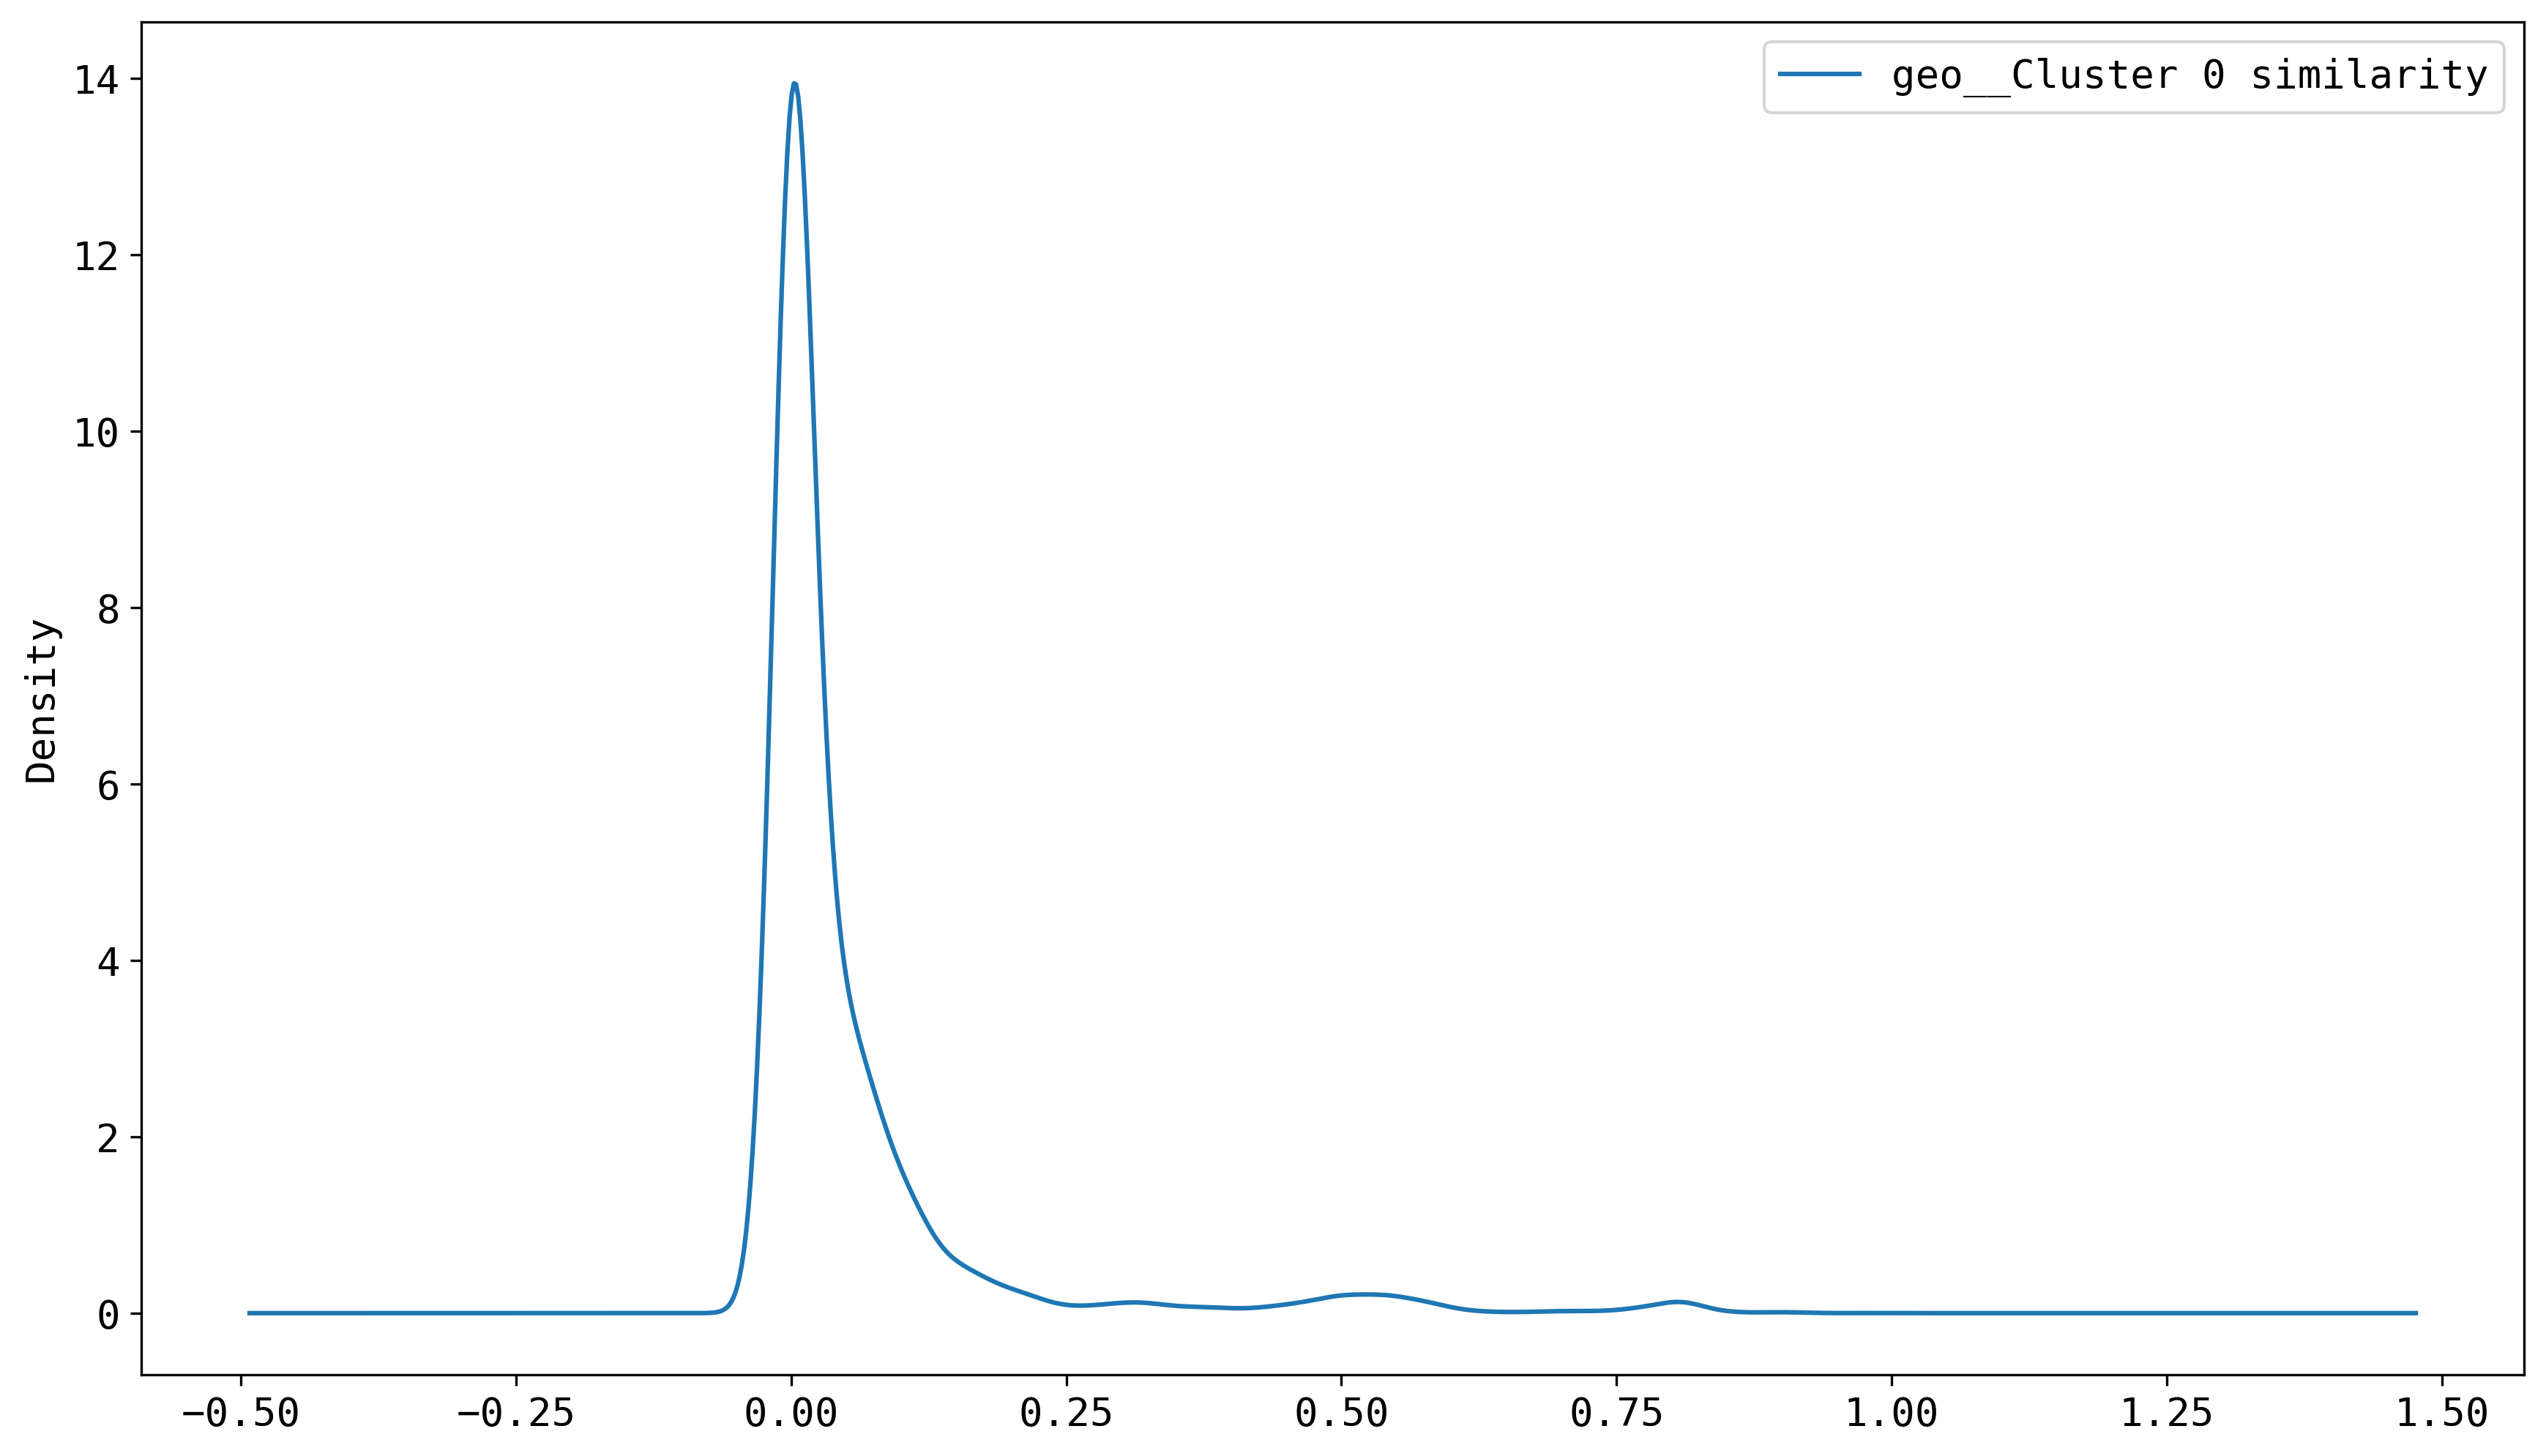

In [51]:
df_housing_prepared[["geo__Cluster 0 similarity"]].plot.kde()

## **MODEL SELECTION & TRAINING**

